# <center>**Board Game Recommender**</center>

<img src='Board_Game.png'>

## **Table of Contents**

1. [Problem Statement](#problem)
2. [Data Loading and Review](#data-loading)
3. [Exploratory Data Analysis (EDA)](#eda)
4. [Data Preprocessing](#data-preprocess)
[<ul>4.1 Numerical Pipeline</ul>](#numeric)
[<ul>4.2 Categorical Pipeline</ul>](#category)
[<ul>4.3 Column Transformers</ul>](#column)
5. [Model Selection and Training](#selection)
[<ul>5.1 Clustering Models</ul>](#cluster)
[<ul>5.2 Single Input (Proof of Concept)</ul>](#proof)
[<ul>5.3 Multiple Input</ul>](#mult)
6. [Model Evaluation](#evaluation)
7. [Conclusion](#conclude)
8. [Appendix](#append)

---

## **1. Problem Statement** <a class="anchor" id="problem"></a>

The goal of this project is to create a model to recommend board games using the [Board Games Dataset](https://www.kaggle.com/datasets/andrewmvd/board-games) from Kaggle.  This project was created as the capstone project in my Master of Data Science program at Eastern University.  The inspiration for this project came from a desire to improve the board game recommendations from Boardgamegeek.com by evaluating a list of games instead of a single game.  

The dataset author's description of the columns is in the Appendix section.  


## **2. Data Loading and Exploration** <a class="anchor" id="data-loading"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%%html
<style>
table {
  float: left;
}
</style>

In [3]:
board_game_data = pd.read_csv("bgg_dataset.csv")

In [4]:
board_game_data.head()

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,174430.0,Gloomhaven,2017.0,1,4,120,14,42055,8.79,1,3.86,68323.0,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games"
1,161936.0,Pandemic Legacy: Season 1,2015.0,2,4,60,13,41643,8.61,2,2.84,65294.0,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games"
2,224517.0,Brass: Birmingham,2018.0,2,4,120,14,19217,8.66,3,3.91,28785.0,"Hand Management, Income, Loans, Market, Networ...",Strategy Games
3,167791.0,Terraforming Mars,2016.0,1,5,120,12,64864,8.43,4,3.24,87099.0,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games
4,233078.0,Twilight Imperium: Fourth Edition,2017.0,3,6,480,14,13468,8.70,5,4.22,16831.0,"Action Drafting, Area Majority / Influence, Ar...","Strategy Games, Thematic Games"


In [5]:
board_game_data.duplicated().sum()

0

In [6]:
board_game_data.duplicated('Name').sum()

367

There are no duplicated rows in the data.  However, there are 367 games with the same name as another one.  This is likely caused by reprints.  

In [7]:
board_game_data.shape

(20343, 14)

There are a little over 20,000 games in the data, which should be more than enough to make a recommendation engine.  

In [8]:
board_game_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20343 entries, 0 to 20342
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  20327 non-null  float64
 1   Name                20343 non-null  object 
 2   Year Published      20342 non-null  float64
 3   Min Players         20343 non-null  int64  
 4   Max Players         20343 non-null  int64  
 5   Play Time           20343 non-null  int64  
 6   Min Age             20343 non-null  int64  
 7   Users Rated         20343 non-null  int64  
 8   Rating Average      20343 non-null  float64
 9   BGG Rank            20343 non-null  int64  
 10  Complexity Average  20343 non-null  float64
 11  Owned Users         20320 non-null  float64
 12  Mechanics           18745 non-null  object 
 13  Domains             10184 non-null  object 
dtypes: float64(5), int64(6), object(3)
memory usage: 2.2+ MB


In [9]:
board_game_data.isna().sum()

ID                       16
Name                      0
Year Published            1
Min Players               0
Max Players               0
Play Time                 0
Min Age                   0
Users Rated               0
Rating Average            0
BGG Rank                  0
Complexity Average        0
Owned Users              23
Mechanics              1598
Domains               10159
dtype: int64

There are 16 ID's, 23 Owned Users, and 1 year published missing.  That is not as big of a deal as the 1,500 missing mechanics or 10,000 missing domains.  Domains (such as Strategy Game, etc.) are not going to be that important, so that column will likely be removed in the final data, but the mechanics column could be important.  These entries will not be removed from the data, but they will have to be filled in with something for the model to work.  

In [10]:
board_game_data[board_game_data['ID'].isna()]

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
10776,NaN,Ace of Aces: Jet Eagles,1990.0,2,2,20,10,110,6.26,10778,2.00,NaN,NaN,NaN
10835,NaN,Die Erben von Hoax,1999.0,3,8,45,12,137,6.05,10837,2.00,NaN,NaN,NaN
11152,NaN,Rommel in North Africa: The War in the Desert ...,1986.0,2,2,0,12,53,6.76,11154,4.00,NaN,NaN,NaN
11669,NaN,Migration: A Story of Generations,2012.0,2,4,30,12,49,7.20,11671,2.00,NaN,NaN,NaN
12649,NaN,Die Insel der steinernen Wachter,2009.0,2,4,120,12,49,6.73,12651,3.00,NaN,NaN,NaN
12764,NaN,Dragon Ball Z TCG (2014 edition),2014.0,2,2,20,8,33,7.03,12766,2.50,NaN,NaN,NaN
13282,NaN,Dwarfest,2014.0,2,6,45,12,82,6.13,13284,1.75,NaN,NaN,NaN
13984,NaN,Hus,NaN,2,2,40,0,38,6.28,13986,2.00,NaN,NaN,NaN
14053,NaN,Contrario 2,2006.0,2,12,0,14,37,6.30,14055,1.00,NaN,NaN,NaN
14663,NaN,Warage: Extended Edition,2017.0,2,6,90,10,49,7.64,14665,3.00,NaN,NaN,NaN


In [11]:
board_game_data[board_game_data['Year Published'].isna()]

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
13984,NaN,Hus,NaN,2,2,40,0,38,6.28,13986,2.0,NaN,NaN,NaN


In [12]:
board_game_data[board_game_data['Owned Users'].isna()]

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
2828,202755.0,Guildhall Fantasy: Fellowship,2016.0,2,4,45,10,565,7.13,2830,2.00,NaN,"Hand Management, Take That, Set Collection",NaN
3590,196305.0,Guildhall Fantasy: Alliance,2016.0,2,4,45,10,360,7.20,3592,2.14,NaN,"Hand Management, Set Collection, Take That",NaN
3739,196306.0,Guildhall Fantasy: Coalition,2016.0,2,4,45,10,336,7.19,3741,2.13,NaN,"Hand Management, Set Collection, Take That",NaN
5807,289.0,Chariot Lords,1999.0,3,4,360,12,221,6.68,5809,3.00,NaN,"Area Movement, Variable Player Powers",NaN
9202,6813.0,Operation Market Garden: Descent into Hell,1985.0,2,2,120,12,94,6.72,9204,3.00,NaN,"Dice Rolling, Events, Grid Movement, Hexagon G...",NaN
9317,139.0,Hoax,1981.0,3,12,45,10,216,5.97,9319,1.38,NaN,"Deduction, Hidden Roles, Voting",NaN
10075,266756.0,Devil Boats: PT Boats in the Solomons,2021.0,1,1,60,14,49,7.84,10077,2.83,NaN,NaN,NaN
10776,NaN,Ace of Aces: Jet Eagles,1990.0,2,2,20,10,110,6.26,10778,2.00,NaN,NaN,NaN
10835,NaN,Die Erben von Hoax,1999.0,3,8,45,12,137,6.05,10837,2.00,NaN,NaN,NaN
11152,NaN,Rommel in North Africa: The War in the Desert ...,1986.0,2,2,0,12,53,6.76,11154,4.00,NaN,NaN,NaN


## **3. Exploratory Data Analysis (EDA)** <a class="anchor" id="eda"></a>

In [13]:
board_game_data[['Min Players', 'Max Players', 'Play Time', 'Min Age', 'Users Rated', 'Rating Average', 
                 'Complexity Average', 'Owned Users', 'Year Published']].describe()


,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,Complexity Average,Owned Users,Year Published
count,20343.000000,20343.000000,20343.000000,20343.000000,20343.000000,20343.000000,20343.000000,20320.000000,20342.000000
mean,2.019712,5.672221,91.294548,9.601485,840.971391,6.403227,1.991188,1408.457628,1984.249877
std,0.690366,15.231376,545.447203,3.645458,3511.562220,0.935911,0.848903,5040.179315,214.003181
min,0.000000,0.000000,0.000000,0.000000,30.000000,1.050000,0.000000,0.000000,-3500.000000
25%,2.000000,4.000000,30.000000,8.000000,55.000000,5.820000,1.330000,146.000000,2001.000000
50%,2.000000,4.000000,45.000000,10.000000,120.000000,6.430000,1.970000,309.000000,2011.000000
75%,2.000000,6.000000,90.000000,12.000000,385.000000,7.030000,2.540000,864.000000,2016.000000
max,10.000000,999.000000,60000.000000,25.000000,102214.000000,9.580000,5.000000,155312.000000,2022.000000


Several things stand out from this summary above:

  1. The mean number of minimum players is 2, and the max is 10.  There must be some very large games in the data, and 
    that should be ok to leave as is.   
  2. The minimum of minimum age is 0, which needs to be investigated further.  Is that an error or just meaning anyone can play the game?  Same question for minimum play time.
  3.  The mean max players is around 6, but the maximum is 999.  Those are very large games, and it is unlikely many games   have that requirement.  Those games should be looked at and possibly removed or capped.  Alternatively, this column could be scaled to accommodate this large difference in maximum player counts.   
  4.  The mean play time is 90 minutes, but the maximum is 60,000 mins (1000 hours or 41 days)!  That is a huge 
    difference, and once again will need capped or scaled in the final model.  
  5.  The minimum of complexity average is 0 even if the scale is from 1 - 5.  That must be an error that needs to be corrected in the final data.
  6.  The games were all published before 2023, so that will be a limitation of the model.  
 


C:\Users\ejb51\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Minimum Age')

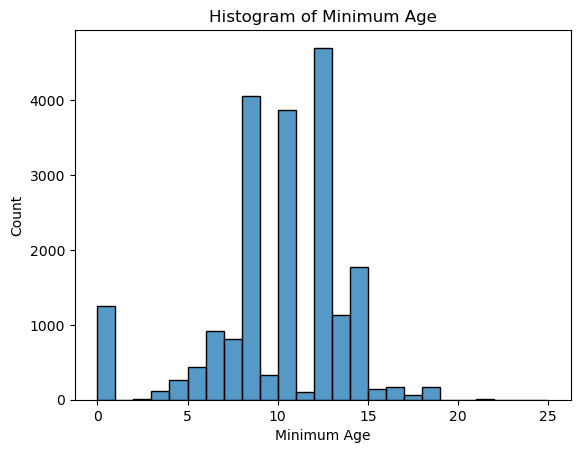

In [14]:
sns.histplot(board_game_data, x='Min Age', binwidth=1)
plt.title('Histogram of Minimum Age')
plt.xlabel('Minimum Age')

The majority of the games fall between the 8 to 14 age range, which makes sense for modern games.

C:\Users\ejb51\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Histogram of Rating Average')

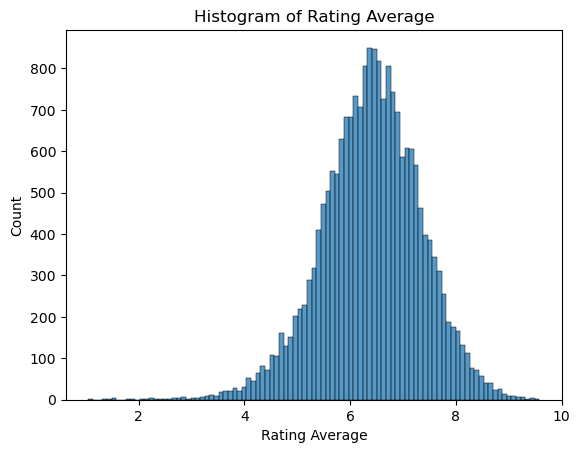

In [15]:
sns.histplot(board_game_data, x='Rating Average')
plt.title('Histogram of Rating Average')

The rating average is normally distributed with a mean of around 6.5.

C:\Users\ejb51\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Histogram of Play Time')

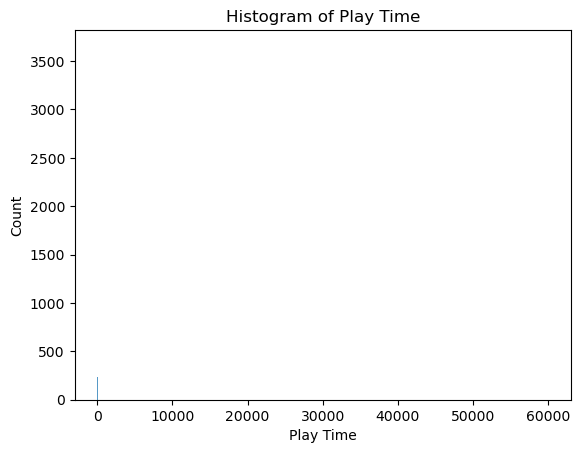

In [16]:
sns.histplot(board_game_data, x='Play Time')
plt.title('Histogram of Play Time')

As expected, the 60000 minute outlier drastically skewed the histogram of play time.  Theat needs to be investigated and removed to see the shape of the rest of the data.

In [17]:
board_game_data.sort_values(by='Play Time', ascending=False).head(200)

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
13420,4815.0,The Campaign for North Africa: The Desert War ...,1979.0,8,10,60000,14,146,6.10,13422,4.71,385.0,"Dice Rolling, Hexagon Grid, Simulation",Wargames
3208,29285.0,Case Blue,2007.0,2,2,22500,12,289,8.26,3210,4.58,711.0,"Dice Rolling, Hexagon Grid, Simulation",Wargames
6035,46669.0,1914: Offensive à outrance,2013.0,2,4,17280,0,108,7.98,6037,4.07,661.0,"Dice Rolling, Hexagon Grid, Simulation",Wargames
7895,158793.0,Atlantic Wall: D-Day to Falaise,2014.0,2,6,14400,16,69,8.08,7897,4.89,328.0,"Hexagon Grid, Zone of Control",Wargames
9497,6942.0,Drang Nach Osten!,1973.0,2,4,12000,12,77,6.82,9499,4.22,192.0,"Dice Rolling, Hexagon Grid, Simulation",Wargames
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8133,188124.0,Ostroleka 26 maja 1831,2015.0,2,4,600,16,82,8.95,8135,4.18,103.0,"Dice Rolling, Hexagon Grid, Variable Phase Order",Wargames
2397,125977.0,Cataclysm: A Second World War,2018.0,2,5,600,14,554,7.66,2399,3.85,1568.0,"Area Majority / Influence, Area Movement, Chit...",Wargames
12165,16169.0,Gettysburg: High Tide of the Confederacy,1982.0,2,8,600,12,33,7.23,12167,3.29,134.0,"Dice Rolling, Grid Movement, Hexagon Grid, Lin...",Wargames
6910,190462.0,Triumph of Chaos v.2 (Deluxe Edition),2019.0,2,2,600,16,74,8.32,6912,4.93,337.0,"Campaign / Battle Card Driven, Dice Rolling, M...",Wargames


There are at least 200 games with a play time of 600 minutes (6 hours) or higher.  The data will be filtered to remove entries above 600 just to see the shape of the rest of the data. 

C:\Users\ejb51\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Histogram of Play Time (<= 600 minutes)')

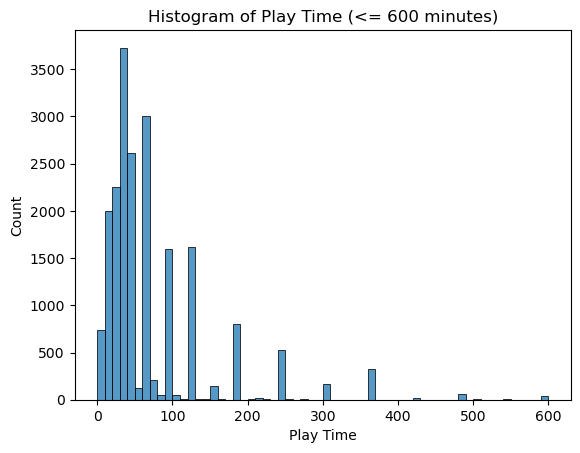

In [18]:
hist_data_under_600 = board_game_data[board_game_data['Play Time'] <= 600]
sns.histplot(hist_data_under_600, x='Play Time', binwidth=10)
plt.title('Histogram of Play Time (<= 600 minutes)')

After removing the high outliers, it appears that most games fall between 50 to 80 minutes, which is a reasonable play time for most games.

C:\Users\ejb51\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Minimum Players')

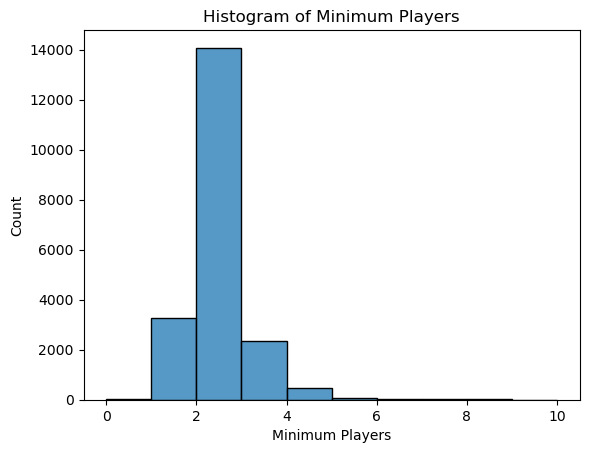

In [19]:
sns.histplot(board_game_data, x='Min Players', binwidth=1)
plt.title('Histogram of Minimum Players')
plt.xlabel('Minimum Players')

The majority of games require at least 2 players to play.  

C:\Users\ejb51\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Max Players', ylabel='Count'>

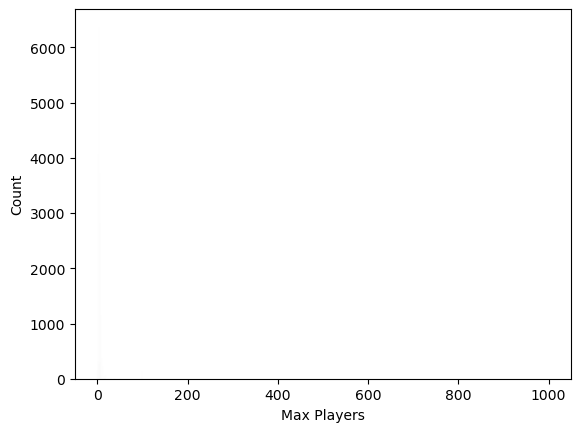

In [20]:
sns.histplot(board_game_data, x='Max Players')

As expected, the 999 player outlier skewed the distribution for the maximum number of players.  That needs to be reviewed further.  

In [21]:
board_game_data.sort_values(by='Max Players', ascending=False).head(250)

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
10813,189890.0,Scrimish Card Game,2015.0,2,999,100,8,254,5.90,10815,1.13,898.0,Memory,NaN
8516,28567.0,"I Don't Know, What Do You Want to Play?",2007.0,2,999,5,8,87,6.76,8518,1.06,117.0,Voting,NaN
7025,24996.0,Start Player: A Kinda Collectible Card Game,2006.0,2,999,1,6,178,6.49,7027,1.00,286.0,NaN,"Family Games, Party Games"
18781,3867.0,The Hammer of Thor: The Game of Norse Mythology,1980.0,1,362,120,12,60,4.95,18783,3.50,179.0,"Dice Rolling, Events, Paper-and-Pencil, Role P...",NaN
4913,147194.0,Linkee!,2012.0,2,200,30,14,523,6.33,4915,1.17,1225.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18733,13935.0,7 Deadly Sins,2003.0,2,21,60,18,40,4.77,18735,1.50,122.0,"Acting, Dice Rolling, Role Playing",NaN
4424,141653.0,Disc Duelers,2013.0,2,21,45,10,362,6.68,4426,1.33,851.0,"Flicking, Team-Based Game, Variable Player Powers",NaN
3466,47046.0,Gambit 7,2008.0,3,21,15,7,577,6.70,3468,1.06,659.0,Betting and Bluffing,Party Games
12822,12160.0,APBA American Saddle Racing,1970.0,1,20,30,0,44,6.80,12824,1.00,61.0,Simulation,NaN


There are over 250 games in the data that have a maximum number of players of 20 or above.  The data will be filtered to remove those to see what the rest of the shape looks like.  

C:\Users\ejb51\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


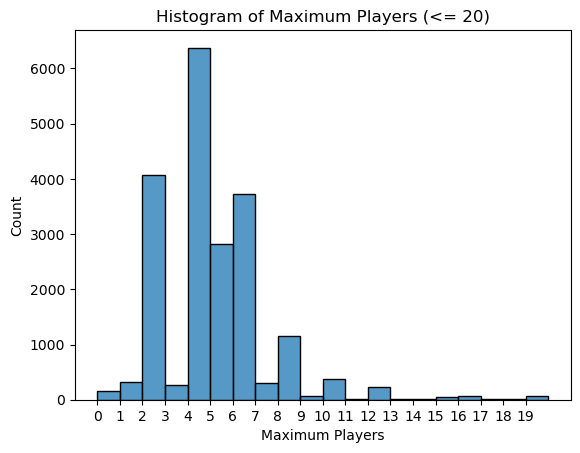

In [22]:
hist_data_under_20 = board_game_data[board_game_data['Max Players'] <= 20]
plot = sns.histplot(hist_data_under_20, x='Max Players', binwidth=1)
plt.title('Histogram of Maximum Players (<= 20)')
plt.xlabel('Maximum Players')
plot.set_xticks(range(0, 20, 1))
plt.show()

The majority of games can have up to 4 players, while several games are 2 player, 5, player, or even 6 player.  Games above 8 players are rare.  

In [23]:
board_game_data['Domains'].value_counts()

Domains
Wargames                                          3029
Strategy Games                                    1455
Family Games                                      1340
Abstract Games                                     869
Children's Games                                   708
Thematic Games                                     647
Party Games                                        409
Family Games, Strategy Games                       354
Customizable Games                                 235
Strategy Games, Thematic Games                     217
Thematic Games, Wargames                           139
Family Games, Party Games                          139
Abstract Games, Family Games                       116
Family Games, Thematic Games                       109
Children's Games, Family Games                     105
Strategy Games, Wargames                            99
Abstract Games, Strategy Games                      40
Party Games, Thematic Games                         36
Cu

In [24]:
board_game_data['Domains'].unique().shape

(40,)

In [25]:
board_game_data['Mechanics'].value_counts()

Mechanics
Hand Management                                                                                                 432
Hexagon Grid                                                                                                    412
Dice Rolling                                                                                                    372
Roll / Spin and Move                                                                                            369
Tile Placement                                                                                                  285
                                                                                                               ... 
Dice Rolling, Measurement Movement, Pick-up and Deliver, Variable Player Powers, Variable Set-up                  1
Action Points, Dice Rolling, Grid Movement, Modular Board, Variable Phase Order, Variable Player Powers           1
Area Movement, Hidden Movement, Secret Unit Deployment, Team-B

The structure of the data above helps with how it will need to be encoded later.  It looks like each mechanic or domain is split with a ", ".

In [26]:
board_game_data['Mechanics'].unique().shape

(7382,)

Text(0.5, 1.0, 'Scatter Plot of Complexity Average vs. Rating Average')

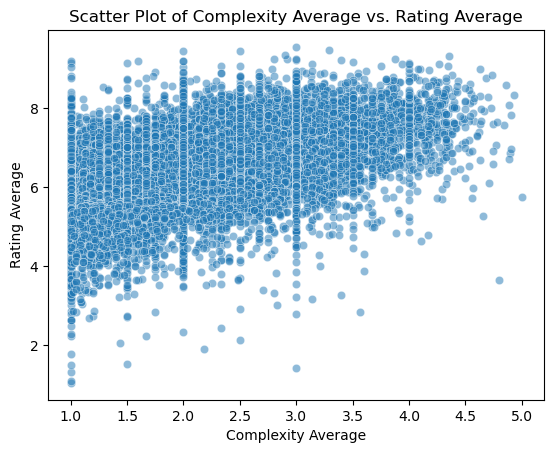

In [27]:
plot_data_wihtout_0_rating = board_game_data[board_game_data['Complexity Average'] > 0]
sns.scatterplot(plot_data_wihtout_0_rating, y='Rating Average', x='Complexity Average', alpha=0.5)
plt.title('Scatter Plot of Complexity Average vs. Rating Average')

It does appear that the spread of rating average does get narrower as complexity average increases.  However, that could also be related to the number of ratings decreasing with higher game complexity.  That will be explored below.

Text(0.5, 1.0, 'Scatter Plot of Complexity Average vs. Users Rated')

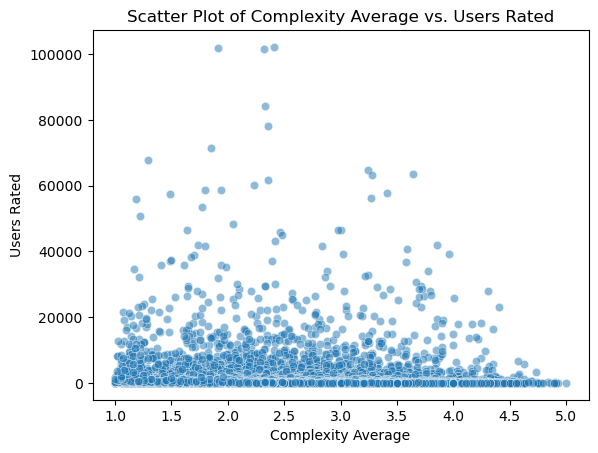

In [28]:
plot_data_wihtout_0_rating = board_game_data[board_game_data['Complexity Average'] > 0]
sns.scatterplot(plot_data_wihtout_0_rating, y='Users Rated', x='Complexity Average', alpha=0.5)
plt.title('Scatter Plot of Complexity Average vs. Users Rated')

It does appear that the number of users who rated the game does tend to decrease with higher complexity average.

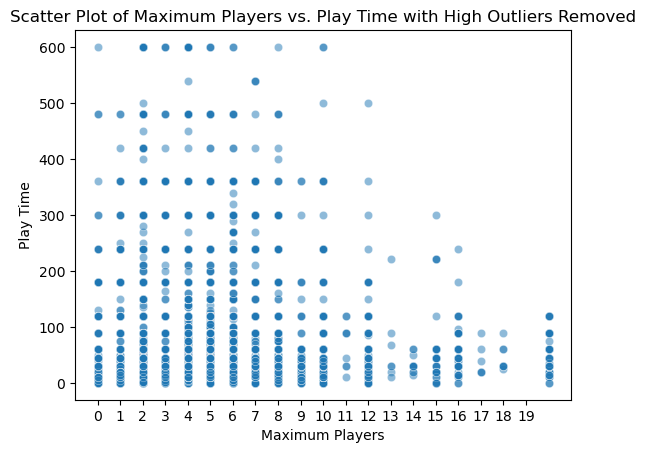

In [29]:
plot_data_no_high_outliers = board_game_data[(board_game_data['Max Players'] <= 20) & (board_game_data['Play Time'] <= 600)]
plot = sns.scatterplot(plot_data_no_high_outliers, x="Max Players", y='Play Time', alpha=0.5)
plt.title('Scatter Plot of Maximum Players vs. Play Time with High Outliers Removed')
plt.xlabel('Maximum Players')
plot.set_xticks(range(0, 20, 1))
plt.show()

There does not appear to be a relationship between the number of players for a game and the play time.

Text(0.5, 1.0, 'Scatter Plot of BGG Rank vs. Owned Users')

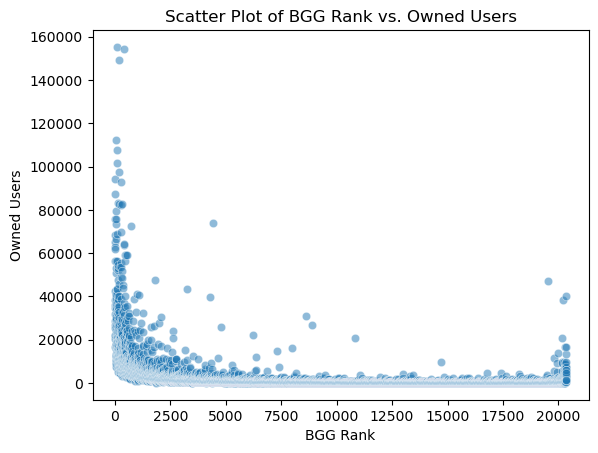

In [30]:
sns.scatterplot(board_game_data, y='Owned Users', x='BGG Rank', alpha=0.5)
plt.title('Scatter Plot of BGG Rank vs. Owned Users')

In general, the higher ranked games (1 being the highest rank) have more users who own them.  This will be important when deciding to use either variable in the final model.  

## **4. Data Preprocessing** <a class="anchor" id="data-preprocess"></a>

The following columns need to be removed before feeding the data into the model: 

  * ID:  Not needed and is missing values
  * Year Published:  The model's job is to recommend games that are similar, and having this field may skew the model towards games within the time period of the input, which is undesirable.
  * BGG Rank:  Keeping this will skew the model to similar ranking games.

In [31]:
names = board_game_data['Name']
features = board_game_data.drop(['Name', 'ID', 'Year Published', 'BGG Rank'], axis=1)

### 4.2 Numerical Pipeline <a class="anchor" id="numeric"></a>

Since the model will work on content-filtering, the numerical features that are not intrinsically tied to the game will be removed.  The following columns will be removed from the model:  

  * Users Rated/Owned Users:  The number of users that rate or own the game is not a specific attribute of the game itself
  * Rating Average:  A game is given a subjective rating by the players, but it is not printed with a specific rating
  * Complexity Average:  While games are printed with a certain understanding of their difficulty, component counts, etc., the actual complexity rating is assessed by the players and not the game publishers.
  * Min Age:  While game companies do rate games by appropriate ages, this feature will be used later during filtering.
  * Max Players:  While games do come with a set number of players who can play the game, this feature will be used later in filtering and the results of using it within the model may exclude some games based on it.  After all, people can play games with different player counts.  


In [32]:
num_attributes = features.select_dtypes(np.number).drop(['Users Rated', 'Rating Average', 'Owned Users', 'Complexity Average','Min Age','Max Players'], axis=1).columns.tolist()
num_attributes


['Min Players', 'Play Time']

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

In [34]:
# Test
num_pipeline.fit_transform(features[num_attributes])

array([[-1.4770968 ,  0.05262866],
       [-0.0285536 , -0.05737552],
       [-0.0285536 ,  0.05262866],
       ...,
       [-0.0285536 , -0.11237761],
       [-0.0285536 , -0.11237761],
       [-0.0285536 , -0.1655463 ]])

### 4.3 Categorical Pipeline <a class="anchor" id="category"></a>

In [35]:
cat_attributes = ['Domains', 'Mechanics']
cat_attributes

['Domains', 'Mechanics']

In [36]:
domains_unique = list(features['Domains'].str.split(',').explode('Domains').fillna('None').str.strip().unique())

In [37]:
mechanics_unique = list(features['Mechanics'].str.split(',').explode('Mechanics').fillna('None').str.strip().unique())

In [38]:
def split_columns(data):
    indicator = 0
    column_names = []
    data_values = []
    results_df = pd.DataFrame()

    for mechanic in mechanics_unique:
        column_name = str('Mechanic_' + mechanic + '_' + str(indicator))

        column_values = []

        for index, row in data.iterrows():
            if mechanic in str(row['Mechanics']):
                column_values.append(1)
            else:
                column_values.append(0)

        column_names.append(column_name)
        data_values.append(column_values)
    
        indicator += 1

    results_df = pd.DataFrame(np.array(data_values).T, columns=column_names, index=data.index)
    data_1 = pd.concat([data, results_df], axis=1)  
        
    indicator = 0
    column_names = []
    data_values = []
    results_df = pd.DataFrame()

    for domain in domains_unique:
        column_name = str('Domain_' + domain + '_' + str(indicator))

        column_values = []

        for index, row in data.iterrows():
            if domain in str(row['Domains']):
                column_values.append(1)
            else:
                column_values.append(0)

        column_names.append(column_name)
        data_values.append(column_values)
                                  
        indicator += 1

    results_df = pd.DataFrame(np.array(data_values).T, columns=column_names, index=data.index)
    return pd.concat([data_1, results_df], axis=1).drop(['Mechanics', 'Domains'], axis=1)   
    

In [39]:
from sklearn.preprocessing import FunctionTransformer

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='None').set_output(transform="pandas"),
    FunctionTransformer(func=split_columns, validate=False).set_output(transform="pandas"),
)

In [40]:
# Test
pd.DataFrame(cat_pipeline.fit_transform(features[cat_attributes]))

,Mechanic_Action Queue_0,Mechanic_Action Retrieval_1,Mechanic_Campaign / Battle Card Driven_2,Mechanic_Card Play Conflict Resolution_3,Mechanic_Communication Limits_4,Mechanic_Cooperative Game_5,Mechanic_Deck Construction_6,Mechanic_Deck Bag and Pool Building_7,Mechanic_Grid Movement_8,Mechanic_Hand Management_9,...,Mechanic_Hot Potato_182,Domain_Strategy Games_0,Domain_Thematic Games_1,Domain_Wargames_2,Domain_Family Games_3,Domain_Customizable Games_4,Domain_Abstract Games_5,Domain_Party Games_6,Domain_Children's Games_7,Domain_None_8
0,1,1,1,1,1,1,1,1,1,1,...,0,1,1,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,1,...,0,1,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20338,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
20339,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20340,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
20341,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


### 4.4 Column Transformers <a class="anchor" id="column"></a>

Two different column transformers will be created to look at the differences between using the numerical features or excluding them from the data.  

In [41]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

preprocessor_without_num = ColumnTransformer([
    ('cat', cat_pipeline, cat_attributes)
], remainder='drop')

preprocessor_with_num = ColumnTransformer([
    ('num', num_pipeline, num_attributes),
    ('cat', cat_pipeline, cat_attributes)
], remainder='drop')

In [42]:
features_fitted_with_num = preprocessor_with_num.fit_transform(features)
pd.DataFrame(features_fitted_with_num)

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
0,-1.477097,0.052629,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.028554,-0.057376,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.028554,0.052629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.477097,0.052629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.419990,0.712654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20338,-0.028554,-0.112378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
20339,-0.028554,-0.057376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
20340,-0.028554,-0.112378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
20341,-0.028554,-0.112378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [43]:
features_fitted_without_num = preprocessor_without_num.fit_transform(features)
pd.DataFrame(features_fitted_without_num)

,0,1,2,3,4,5,6,7,8,9,...,182,183,184,185,186,187,188,189,190,191
0,1,1,1,1,1,1,1,1,1,1,...,0,1,1,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,1,...,0,1,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20338,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
20339,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20340,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
20341,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


## **5. Model Selection and Training** <a class="anchor" id="selection"></a>

### 5.1 Clustering Models <a class="anchor" id="cluster"></a>

### K-Means Clustering

In [44]:
from sklearn.cluster import KMeans

In [45]:
%%time
intertias = []
for i in range(1, 100):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(features_fitted_with_num)
    intertias.append(kmeans.inertia_) 

CPU times: total: 4min 24s
Wall time: 23.4 s


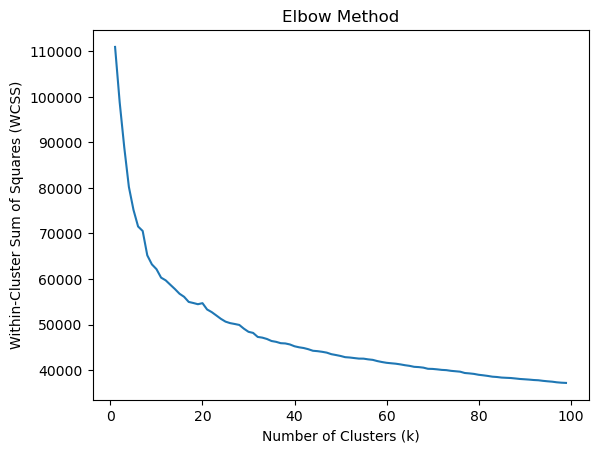

In [46]:
plt.plot(range(1, 100), intertias)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()

In [49]:
# clusters_above_10 = []

# for i in range(1, 5000, 100):
#     kmeans = KMeans(n_clusters=i, random_state=0, n_init='auto')
#     kmeans.fit_predict(features_fitted_with_num)
#     clusters_above_10.append((pd.DataFrame(kmeans.labels_).value_counts() > 10).sum())

# sns.scatterplot(y=clusters_above_10, x=range(1, 5000, 100))

In [50]:
%%time
kmeans = KMeans(n_clusters=1000, random_state=0, n_init='auto')
kmeans.fit_predict(features_fitted_with_num)

pd.DataFrame(kmeans.labels_).value_counts()

CPU times: total: 20.8 s
Wall time: 4.1 s


15     768
85     338
68     259
35     256
36     216
      ... 
509      1
872      1
1        1
876      1
481      1
Name: count, Length: 1000, dtype: int64

In [51]:
(pd.DataFrame(kmeans.labels_).value_counts() > 10).sum()

588

In [52]:
(pd.DataFrame(kmeans.labels_).value_counts() == 1).sum()

101

In [55]:
(pd.DataFrame(kmeans.labels_).value_counts() == 2).sum()

45

### K-Means Clustering with PCA

In [56]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(features_fitted_with_num)

PCA()

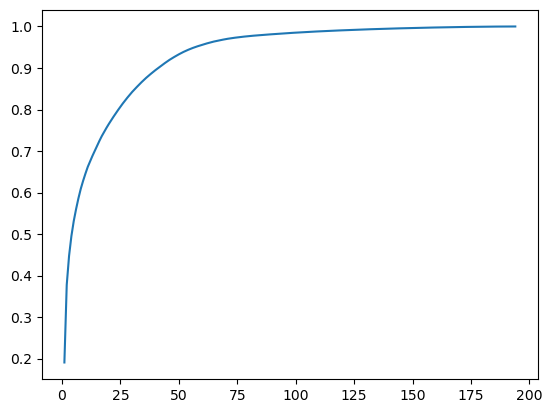

In [57]:
pca_var = pca.explained_variance_ratio_
plt.plot(range(1, len(pca_var) + 1), pca.explained_variance_ratio_.cumsum())

In [58]:
pca = PCA(n_components=50)
principal_components = pca.fit_transform(features_fitted_with_num)

In [59]:
%%time
intertias = []
for i in range(1, 100):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(principal_components)
    intertias.append(kmeans.inertia_) 

CPU times: total: 2min 25s
Wall time: 11.8 s


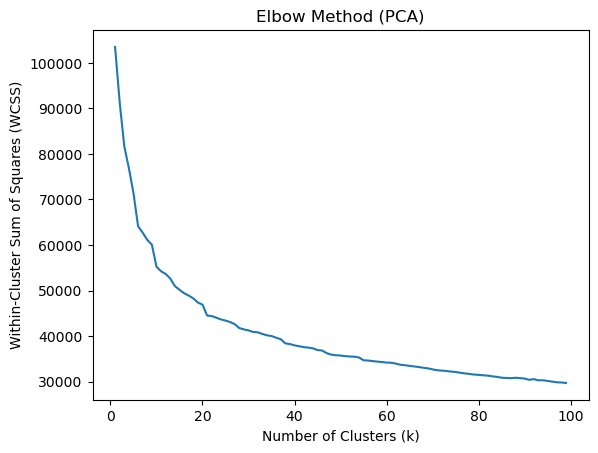

In [60]:
plt.plot(range(1, 100), intertias)
plt.title('Elbow Method (PCA)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()

In [61]:
# clusters_above_10 = []

# for i in range(1, 5000, 100):
#     kmeans_pca = KMeans(n_clusters=i, random_state=0, n_init='auto')
#     kmeans_pca.fit_predict(principal_components)
#     clusters_above_10.append((pd.DataFrame(kmeans_pca.labels_).value_counts() > 10).sum())

# sns.scatterplot(y=clusters_above_10, x=range(1, 5000, 100))

In [62]:
%%time
kmeans_pca = KMeans(n_clusters=1000, random_state=0, n_init='auto')
kmeans_pca.fit_predict(principal_components)

pd.DataFrame(kmeans_pca.labels_).value_counts()

CPU times: total: 14 s
Wall time: 4.05 s


15     768
12     261
16     251
72     229
71     226
      ... 
961      1
962      1
966      1
819      1
760      1
Name: count, Length: 1000, dtype: int64

In [63]:
(pd.DataFrame(kmeans_pca.labels_).value_counts() > 10).sum()

612

In [64]:
(pd.DataFrame(kmeans_pca.labels_).value_counts() == 1).sum()

50

In [65]:
(pd.DataFrame(kmeans_pca.labels_).value_counts() == 2).sum()

29

### Comparing Model Features

In [66]:
kmeans_pca_num = KMeans(n_clusters=1000, random_state=0, n_init='auto')
kmeans_pca_no_num = KMeans(n_clusters=1000, random_state=0, n_init='auto')

pca = PCA(n_components=50)

kmeans_pca_num.fit_predict(pca.fit_transform(features_fitted_with_num))
kmeans_pca_no_num.fit_predict(pca.fit_transform(features_fitted_without_num))

array([482, 242, 258, ...,  12,  93, 842])

In [67]:
clusters_with_num = pd.DataFrame(kmeans_pca_num.labels_, columns=['Cluster_num'])
clusters_without_num = pd.DataFrame(kmeans_pca_no_num.labels_, columns=['Cluster_no_num'])

In [75]:
test_df = pd.concat([names, clusters_with_num, clusters_without_num], axis=1)

In [76]:
test_df = pd.concat([test_df, features[['Min Age', 'Rating Average', 'Users Rated', "Complexity Average", 'Play Time','Min Players', 'Max Players']]], axis=1)

In [77]:
test_df['Custom Rating'] = test_df['Users Rated'] * test_df['Rating Average']

In [78]:
test_df['Name'] = test_df['Name'].str.lower()

In [79]:
target_cluster = test_df[test_df['Name'] == 'chess']['Cluster_num'].iloc[0]
test_df[test_df['Cluster_num'] == target_cluster].sort_values(by='Custom Rating', ascending=False).head(10)

,Name,Cluster_num,Cluster_no_num,Min Age,Rating Average,Users Rated,Complexity Average,Play Time,Min Players,Max Players,Custom Rating
434,chess,45,1,6,7.13,28745,3.70,60,2,2,204951.85
247,onitama,45,468,8,7.40,15161,1.71,20,2,2,112191.40
1204,quoridor,45,1,8,6.67,6393,1.88,15,2,4,42641.31
1627,abalone classic,45,1,7,6.46,6300,2.19,30,2,2,40698.00
20312,checkers,45,1,6,4.88,7182,1.77,30,2,2,35048.16
472,dvonn,45,1,9,7.44,4455,2.67,30,2,2,33145.20
427,tzaar,45,1,13,7.66,3223,2.54,60,2,2,24688.18
1994,khet: the laser game,45,1,9,6.53,2651,2.53,20,2,2,17311.03
815,tak,45,1,12,7.65,2072,2.49,60,2,2,15850.80
1416,kamisado,45,1,10,6.91,2121,2.46,20,2,2,14656.11


In [80]:
target_cluster = test_df[test_df['Name'] == 'chess']['Cluster_no_num'].iloc[0]
test_df[test_df['Cluster_no_num'] == target_cluster].sort_values(by='Custom Rating', ascending=False).head(10)

,Name,Cluster_num,Cluster_no_num,Min Age,Rating Average,Users Rated,Complexity Average,Play Time,Min Players,Max Players,Custom Rating
434,chess,45,1,6,7.13,28745,3.70,60,2,2,204951.85
1204,quoridor,45,1,8,6.67,6393,1.88,15,2,4,42641.31
1627,abalone classic,45,1,7,6.46,6300,2.19,30,2,2,40698.00
20312,checkers,45,1,6,4.88,7182,1.77,30,2,2,35048.16
472,dvonn,45,1,9,7.44,4455,2.67,30,2,2,33145.20
427,tzaar,45,1,13,7.66,3223,2.54,60,2,2,24688.18
1994,khet: the laser game,45,1,9,6.53,2651,2.53,20,2,2,17311.03
815,tak,45,1,12,7.65,2072,2.49,60,2,2,15850.80
1416,kamisado,45,1,10,6.91,2121,2.46,20,2,2,14656.11
1395,xiangqi,45,1,8,7.12,1884,3.59,60,2,2,13414.08


In [81]:
target_cluster = test_df[test_df['Name'] == 'love letter']['Cluster_num'].iloc[0]
test_df[test_df['Cluster_num'] == target_cluster].sort_values(by='Custom Rating', ascending=False).head(10)

,Name,Cluster_num,Cluster_no_num,Min Age,Rating Average,Users Rated,Complexity Average,Play Time,Min Players,Max Players,Custom Rating
283,love letter,489,426,10,7.23,56013,1.19,20,2,4,404973.99
412,junk art,489,426,8,7.43,5449,1.22,30,2,6,40486.07
566,love letter: batman,489,426,10,7.27,5032,1.20,20,2,4,36582.64
484,love letter premium,489,426,8,7.46,4322,1.30,30,2,8,32242.12
843,lovecraft letter,489,260,10,7.23,2974,1.47,15,2,6,21502.02
1761,lost legacy: the starship,489,662,10,6.62,2522,1.28,10,2,4,16695.64
899,love letter,489,426,10,7.67,1694,1.15,20,2,6,12992.98
1445,love letter: the hobbit - the battle of the fi...,489,426,8,7.11,1654,1.26,30,2,4,11759.94
1393,adventure time: love letter,489,426,10,7.22,1601,1.05,20,2,4,11559.22
13462,poo: the card game,489,433,8,5.61,1757,1.10,15,2,8,9856.77


In [82]:
target_cluster = test_df[test_df['Name'] == 'love letter']['Cluster_no_num'].iloc[0]
test_df[test_df['Cluster_no_num'] == target_cluster].sort_values(by='Custom Rating', ascending=False).head(10)

,Name,Cluster_num,Cluster_no_num,Min Age,Rating Average,Users Rated,Complexity Average,Play Time,Min Players,Max Players,Custom Rating
283,love letter,489,426,10,7.23,56013,1.19,20,2,4,404973.99
932,tsuro,35,426,8,6.67,23341,1.24,20,2,8,155684.47
662,red7,215,426,9,6.92,12692,1.70,30,2,4,87828.64
569,k2,282,426,8,7.06,9076,2.26,60,1,5,64076.56
412,junk art,489,426,8,7.43,5449,1.22,30,2,6,40486.07
1469,tsuro of the seas,520,426,8,6.55,5730,1.42,40,2,8,37531.50
2430,get bit!,916,426,7,6.15,6018,1.12,20,3,6,37010.70
566,love letter: batman,489,426,10,7.27,5032,1.20,20,2,4,36582.64
484,love letter premium,489,426,8,7.46,4322,1.30,30,2,8,32242.12
899,love letter,489,426,10,7.67,1694,1.15,20,2,6,12992.98


### 5.2 Single Input (Proof of Concept) <a class="anchor" id="proof"></a>

In [83]:
final_clusters = pd.DataFrame(kmeans_pca.labels_, columns=['Cluster'])
search_df = pd.concat([names, final_clusters], axis=1)

In [84]:
search_df = pd.concat([search_df, features[['Min Age', 'Rating Average', 'Users Rated', "Complexity Average", 'Play Time','Min Players', 'Max Players']]], axis=1)

In [85]:
search_df['Custom Rating'] = search_df['Users Rated'] * search_df['Rating Average']

In [86]:
search_df['Name'] = search_df['Name'].str.lower()

In [88]:
target_cluster = search_df[search_df['Name'] == 'chess']['Cluster'].iloc[0]
search_df[search_df['Cluster'] == target_cluster].sort_values(by='Custom Rating', ascending=False).head(10)

,Name,Cluster,Min Age,Rating Average,Users Rated,Complexity Average,Play Time,Min Players,Max Players,Custom Rating
434,chess,45,6,7.13,28745,3.70,60,2,2,204951.85
247,onitama,45,8,7.40,15161,1.71,20,2,2,112191.40
1204,quoridor,45,8,6.67,6393,1.88,15,2,4,42641.31
1627,abalone classic,45,7,6.46,6300,2.19,30,2,2,40698.00
20312,checkers,45,6,4.88,7182,1.77,30,2,2,35048.16
472,dvonn,45,9,7.44,4455,2.67,30,2,2,33145.20
427,tzaar,45,13,7.66,3223,2.54,60,2,2,24688.18
1994,khet: the laser game,45,9,6.53,2651,2.53,20,2,2,17311.03
815,tak,45,12,7.65,2072,2.49,60,2,2,15850.80
1416,kamisado,45,10,6.91,2121,2.46,20,2,2,14656.11


In [89]:
def recommend_games_from_one_game(board_game, min_age=None, max_play_time=None, min_player_count=None, max_complex_rating=None):
    if board_game.lower() in search_df['Name'].tolist():
        # Select the cluster with the board game in it.  If it belongs to more than one cluster, select the first one.  
        target_cluster = search_df[search_df['Name'] == board_game.lower()]['Cluster'].iloc[0]
        resulting_games = search_df[search_df['Cluster'] == target_cluster].sort_values(by='Custom Rating', ascending=False)
        
        if min_age:
            resulting_games = resulting_games[resulting_games['Min Age'] <= min_age]
            
        if max_play_time:
            resulting_games = resulting_games[resulting_games['Play Time'] <= max_play_time]
            
        if min_player_count:
            resulting_games = resulting_games[resulting_games['Max Players'] >= min_player_count]
            
        if max_complex_rating:
            resulting_games = resulting_games[resulting_games['Complexity Average'] <= max_complex_rating]
        
        if resulting_games.empty:
            return 'No recommendations found'
        else:
            return resulting_games[resulting_games['Name'] != board_game.lower()]['Name'].head(10).str.title().to_list()

    else:
        return f'{board_game} not found'
    

In [90]:
# Test
recommend_games_from_one_game('chess', min_age=10, max_play_time=60, min_player_count=2, max_complex_rating=4)

['Onitama',
 'Quoridor',
 'Abalone Classic',
 'Checkers',
 'Dvonn',
 'Khet: The Laser Game',
 'Kamisado',
 'Xiangqi',
 'Shogi',
 'Pünct']

### 5.3 Multiple Input <a class="anchor" id="mult"></a>

In [110]:
def recommend_games_from_game_list(board_game_list, min_age=None, max_play_time=None, min_player_count=None, max_complex_rating=None):
    cluster_dict = {}
    
    # Remove duplicate entries
    board_game_list = list(set(board_game_list))
    
    # Blank input
    if len(board_game_list) == 0:
        return 'No input received'
    
    # Single input
    elif len(board_game_list) == 1:
        if board_game_list[0].lower() in search_df['Name'].tolist():
            target_cluster = search_df[search_df['Name'] == board_game_list[0].lower()]['Cluster'].iloc[0]
            resulting_games = search_df[search_df['Cluster'] == target_cluster].sort_values(by='Custom Rating', ascending=False)
        else: 
            return f'{board_game_list[0]} not found'
    
    # Multiple input
    else:
        for game in board_game_list:
            
            if game.lower() in search_df['Name'].tolist():
                # Select the cluster with the board game in it.  If it belongs to more than one cluster, select the first one.  
                current_cluster = search_df[search_df['Name'] == game.lower()]['Cluster'].iloc[0]
                
                # Add cluster to dictionary to keep track of how many times it appears
                if current_cluster in cluster_dict:
                    cluster_dict[current_cluster] += 1
                else:
                    cluster_dict[current_cluster] = 1
            
            # Game not found
            else:
                print(f'{game} not found')
        
        if len(cluster_dict) == 0:
            return 'No recommendations found based on search parameters'
        
        else:
        # Loop through clusters to make recommendations
            max_cluster_count = max(cluster_dict.values())
            max_clusters = [key for key, value in cluster_dict.items() if value == max_cluster_count]

            resulting_games = pd.DataFrame()

            for cluster in max_clusters:
                current_games_from_cluster = search_df[search_df['Cluster'] == cluster]
                resulting_games = pd.concat([resulting_games, current_games_from_cluster])

            resulting_games = resulting_games.sort_values(by='Custom Rating', ascending=False)     
        
    # Filtering results
    if min_age:
         resulting_games = resulting_games[resulting_games['Min Age'] <= min_age]
            
    if max_play_time:
         resulting_games = resulting_games[resulting_games['Play Time'] <= max_play_time]
            
    if min_player_count:
        resulting_games = resulting_games[resulting_games['Max Players'] >= min_player_count]
            
    if max_complex_rating:
        resulting_games = resulting_games[resulting_games['Complexity Average'] <= max_complex_rating]
    
    # Printing results
    if len(resulting_games[~resulting_games['Name'].isin([item.lower() for item in board_game_list])]) == 0:
        return 'No recommendations found based on search parameters'
    
    else:
        return resulting_games[~resulting_games['Name'].isin([item.lower() for item in board_game_list])]['Name'].head(20).str.title().str.replace("'S", "'s").to_list()
    
    

In [92]:
# Test blank input
recommend_games_from_game_list([])

'No input received'

In [93]:
# Test single input
recommend_games_from_game_list(['chess'])

['Onitama',
 'Quoridor',
 'Abalone Classic',
 'Checkers',
 'Dvonn',
 'Tzaar',
 'Khet: The Laser Game',
 'Tak',
 'Kamisado',
 'Xiangqi',
 'Shogi',
 'Pünct',
 'Confusion:  Espionage And Deception In The Cold War',
 'Tamsk',
 'Shōbu',
 'Billabong',
 'Laser Chess',
 'Focus',
 'Arimaa',
 'Pick & Pack']

In [94]:
# Test multiple input with same game
recommend_games_from_game_list(['chess', 'chess'])

['Onitama',
 'Quoridor',
 'Abalone Classic',
 'Checkers',
 'Dvonn',
 'Tzaar',
 'Khet: The Laser Game',
 'Tak',
 'Kamisado',
 'Xiangqi',
 'Shogi',
 'Pünct',
 'Confusion:  Espionage And Deception In The Cold War',
 'Tamsk',
 'Shōbu',
 'Billabong',
 'Laser Chess',
 'Focus',
 'Arimaa',
 'Pick & Pack']

In [95]:
# Test single input with invalid name
recommend_games_from_game_list(['chessss'])

'chessss not found'

In [97]:
# Test multiple input with no similar games found
one_cluster_game = search_df[search_df['Cluster'] == 819]['Name'].item()
recommend_games_from_game_list([one_cluster_game])

'No recommendations found based on search parameters'

In [112]:
# Test multiple input with with two invalid entries
recommend_games_from_game_list(['chesSSSs', 'checkEEEers'])

chesSSSs not found
checkEEEers not found


'No recommendations found based on search parameters'

In [98]:
# Test multiple input with with same cluster
recommend_games_from_game_list(['chess', 'checkers'])

['Onitama',
 'Quoridor',
 'Abalone Classic',
 'Dvonn',
 'Tzaar',
 'Khet: The Laser Game',
 'Tak',
 'Kamisado',
 'Xiangqi',
 'Shogi',
 'Pünct',
 'Confusion:  Espionage And Deception In The Cold War',
 'Tamsk',
 'Shōbu',
 'Billabong',
 'Laser Chess',
 'Focus',
 'Arimaa',
 'Pick & Pack',
 'Siam']

In [99]:
# Test multiple input with with two games in same cluster and one in a different cluster
recommend_games_from_game_list(['chess', 'checkers', 'love letter'])

['Onitama',
 'Quoridor',
 'Abalone Classic',
 'Dvonn',
 'Tzaar',
 'Khet: The Laser Game',
 'Tak',
 'Kamisado',
 'Xiangqi',
 'Shogi',
 'Pünct',
 'Confusion:  Espionage And Deception In The Cold War',
 'Tamsk',
 'Shōbu',
 'Billabong',
 'Laser Chess',
 'Focus',
 'Arimaa',
 'Pick & Pack',
 'Siam']

In [149]:
# Test multiple input with with two games in same cluster and two other games in a different cluster
recommend_games_from_game_list(['chess', 'checkers', 'love letter', 'junk art'])

['Onitama',
 'Quoridor',
 'Abalone Classic',
 'Love Letter: Batman',
 'Dvonn',
 'Love Letter Premium',
 'Tzaar',
 'Lovecraft Letter',
 'Khet: The Laser Game',
 'Lost Legacy: The Starship',
 'Tak',
 'Kamisado',
 'Xiangqi',
 'Love Letter: The Hobbit - The Battle Of The Five Armies',
 'Adventure Time: Love Letter',
 'Shogi',
 'Pünct',
 'Poo: The Card Game',
 'Confusion:  Espionage And Deception In The Cold War',
 'Unspeakable Words']

In [101]:
# Test list with filtering
recommend_games_from_game_list(['chess', 'pandemic', 'love letter', 'hanabi', 'rummy', 'the mind'], min_age=10, max_play_time=60)


['Onitama',
 'Potion Explosion',
 'Fluxx',
 'Red7',
 'Pandemic: The Cure',
 'Pandemic: Iberia',
 'Thebes',
 'Schotten Totten',
 'Finca',
 'Quoridor',
 'Abalone Classic',
 'Junk Art',
 'Phase 10',
 'Love Letter: Batman',
 'Keltis',
 'Fabled Fruit',
 'Checkers',
 'Dvonn',
 'Love Letter Premium',
 'Star Fluxx']

In [102]:
# Test list with filtering with no results possible
recommend_games_from_game_list(['love letter'], min_age=0, max_play_time=1, min_player_count=1)


'No recommendations found based on search parameters'

## **6. Model Evaluation** <a class="anchor" id="evaluation"></a>

The following two methods will be used to evaluate the model:

1. Compare a single game's output to the recommendations on Boardgamegeek.com
2. Use random input into the model and manually review the results 

These evaluations are subjective as I am relying on my knowledge of the games and the hobby, so the results could vary.  I have been playing board games for 30 years and I own over 200.  I regularly play new games and keep up with the latest industry trends, news, and reviews.  I would not consider myself an expert, but I definitely know more about it than most people.
 

### Comparison to Boardgamegeek.com

In [125]:
recommend_games_from_game_list(['Chess'])

['Onitama',
 'Quoridor',
 'Abalone Classic',
 'Checkers',
 'Dvonn',
 'Tzaar',
 'Khet: The Laser Game',
 'Tak',
 'Kamisado',
 'Xiangqi',
 'Shogi',
 'Pünct',
 'Confusion:  Espionage And Deception In The Cold War',
 'Tamsk',
 'Shōbu',
 'Billabong',
 'Laser Chess',
 'Focus',
 'Arimaa',
 'Pick & Pack']

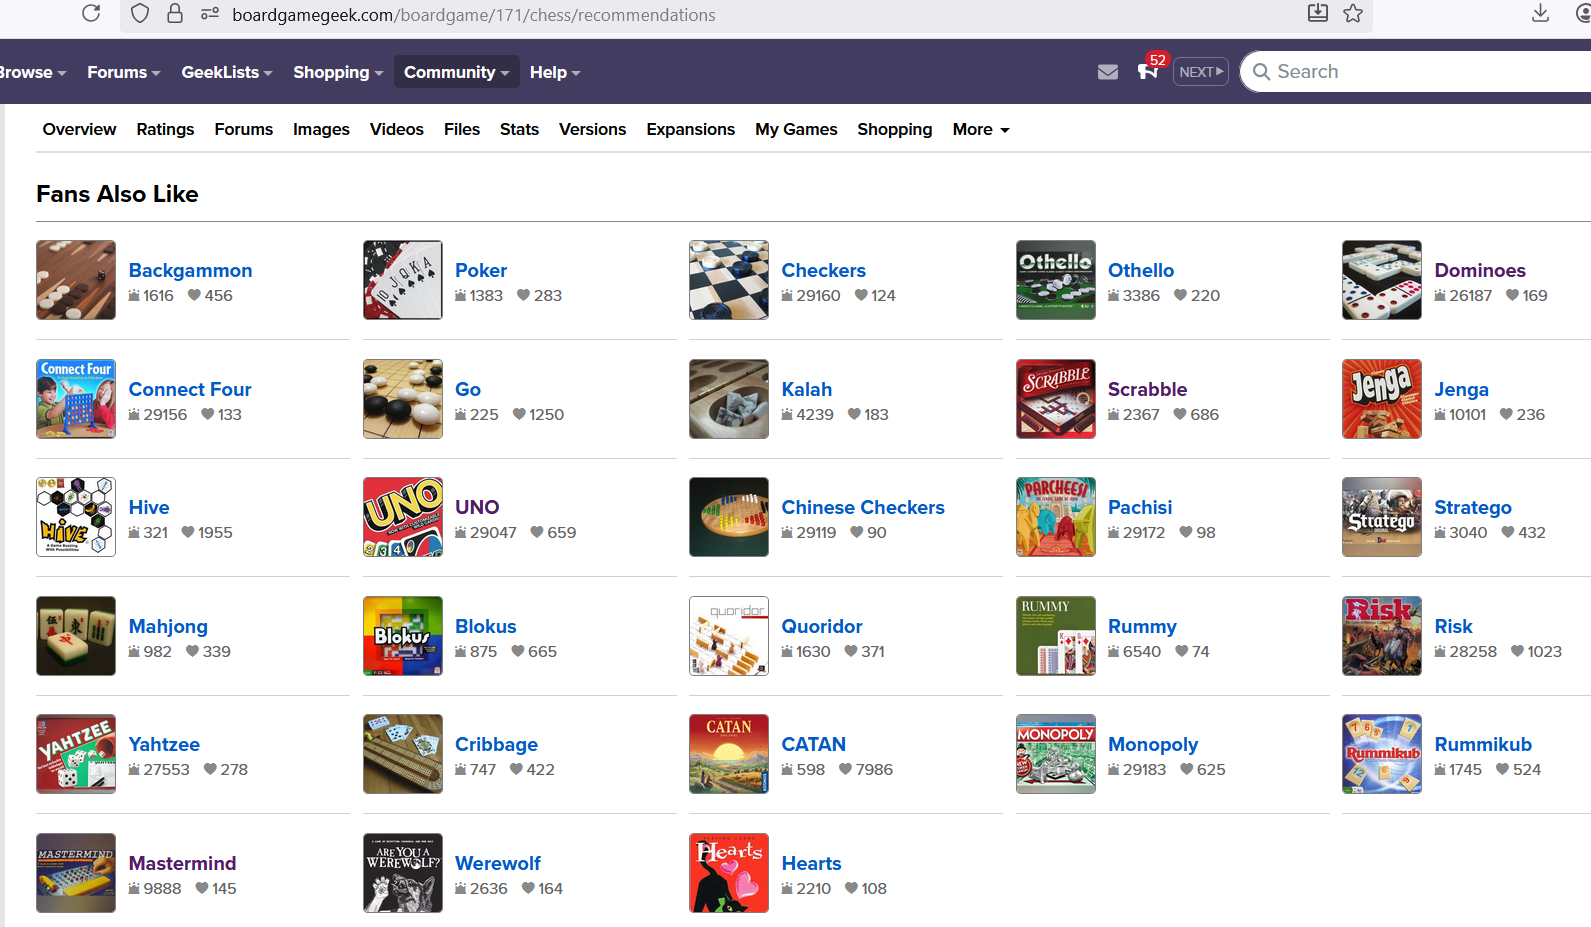

Chess is a 2-player abstract strategy game with no luck involved.  I would expect the recommendations to follow this trend and suggest other strategy games with not a lot of luck.

* Model Results:
    * The majority of the games are in the abstract strategy category, and other than a few, they do not rely on luck (dice or cards)
    * It is notable that both Xiangqi (Chinese Chess) and Shogi (Japanese Chess) are included

* Boardgamegeek Recommendations:
    * Other than Go, Checkers, Othello, Hive, and a couple others, very few of the games are considered abstract strategy  
    * Some games rely heavily on luck (Catan, Poker, Risk, Yahtzee)

Based on this analysis, I conclude that the model gives better recommendations.  


In [148]:
recommend_games_from_game_list(['Love Letter'])

['Junk Art',
 'Love Letter: Batman',
 'Love Letter Premium',
 'Lovecraft Letter',
 'Lost Legacy: The Starship',
 'Love Letter: The Hobbit - The Battle Of The Five Armies',
 'Adventure Time: Love Letter',
 'Poo: The Card Game',
 'Unspeakable Words',
 'The Hobbit Card Game',
 'Lost Legacy: Second Chronicle - Vorpal Sword & Whitegold Spire',
 'Double Down',
 'Boom-O',
 'Palace',
 'Malta!']

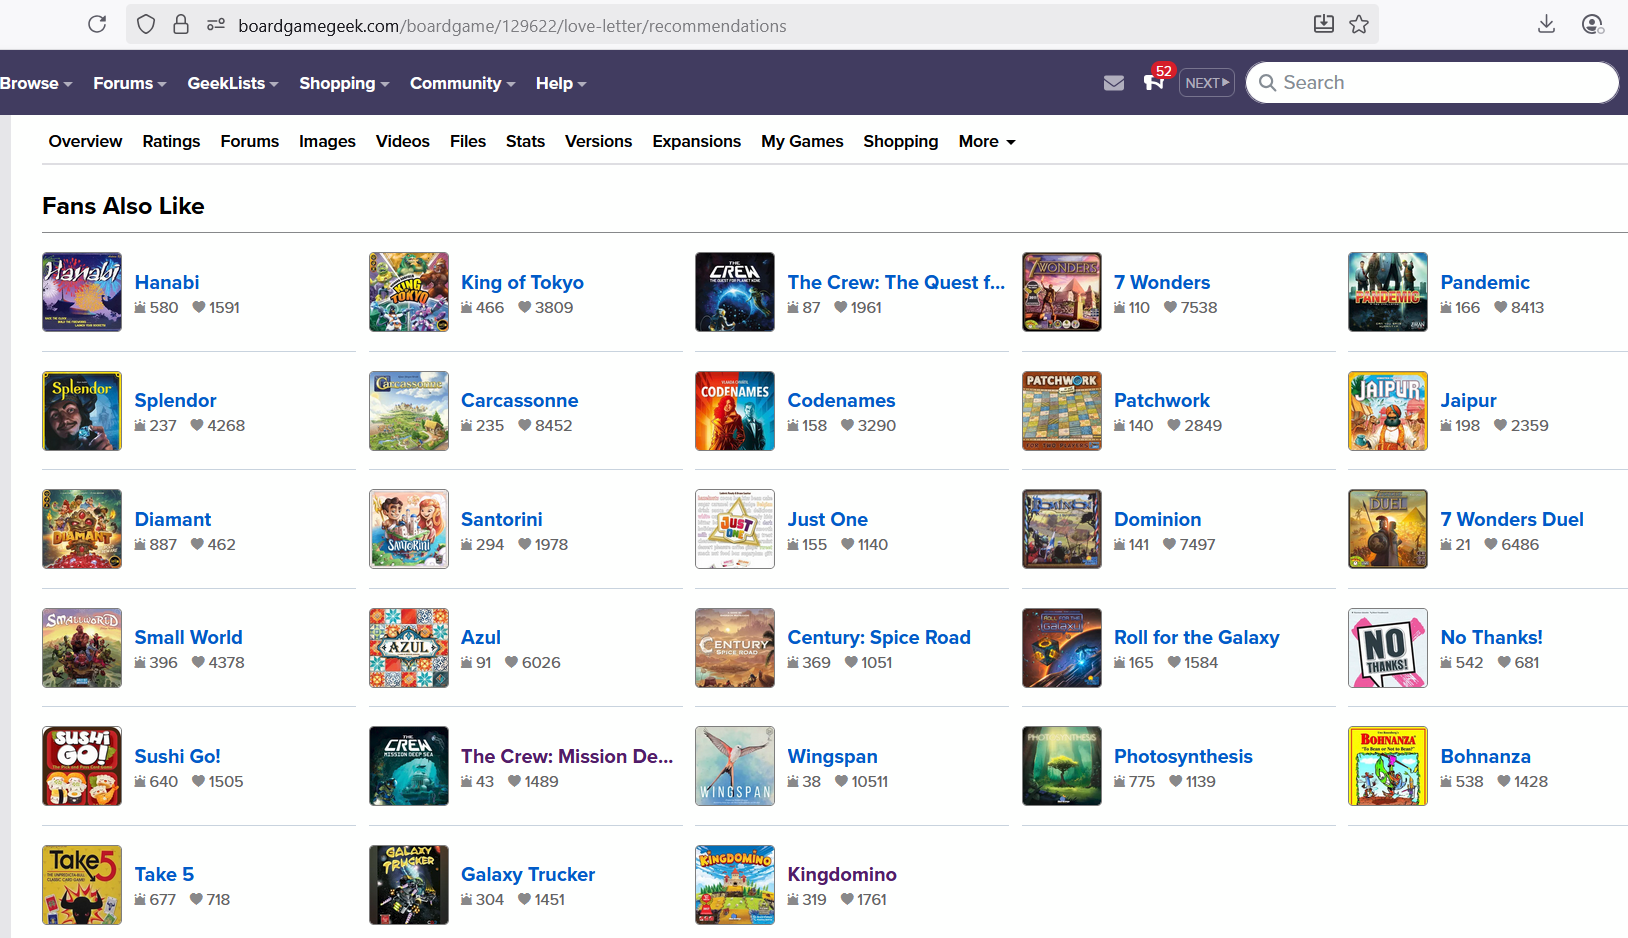

Love Letter is a small card game where players draw and play cards to either eliminate the other player or have the highest card in their hand at the end of the round.  There are many versions of this game, so I would expect recommendations to include them and other small, quick playing card games.

* Model Results:
    * Five other versions of Love Letter as well as the spiritual successor to Love Letter (Lost Legacy) are included  
    * The other games are mostly small card games, which makes sense

* Boardgamegeek Recommendations:
    * No other versions of Love Letter were included in the recommendations, but there are other small card games included (Jaipur, Hanabi, Take 5, Bohnanza, etc.) 
    * Some of the other games are completely different than Love Letter (Pandemic, Azul, Galaxy Trucker, etc.)

Based on this analysis, I conclude that the model gives better recommendations.  


In [144]:
recommend_games_from_game_list(['Uno'])

['Colt Express',
 'Boss Monster: The Dungeon Building Card Game',
 'Disney Villainous',
 'Icecool',
 'Mille Bornes',
 'Beasty Bar',
 'Disney Villainous: Wicked To The Core',
 'Disney Villainous: Evil Comes Prepared',
 'The Bucket King',
 'Dog',
 'Dirty Pig',
 'Disney Villainous: Perfectly Wretched',
 'Fast Forward: Fear',
 'Uno Attack!',
 'Icecool2',
 "Friese's Landlord",
 'Farmageddon',
 'Nile Deluxor',
 'Dino Race',
 'Bucket King 3D']

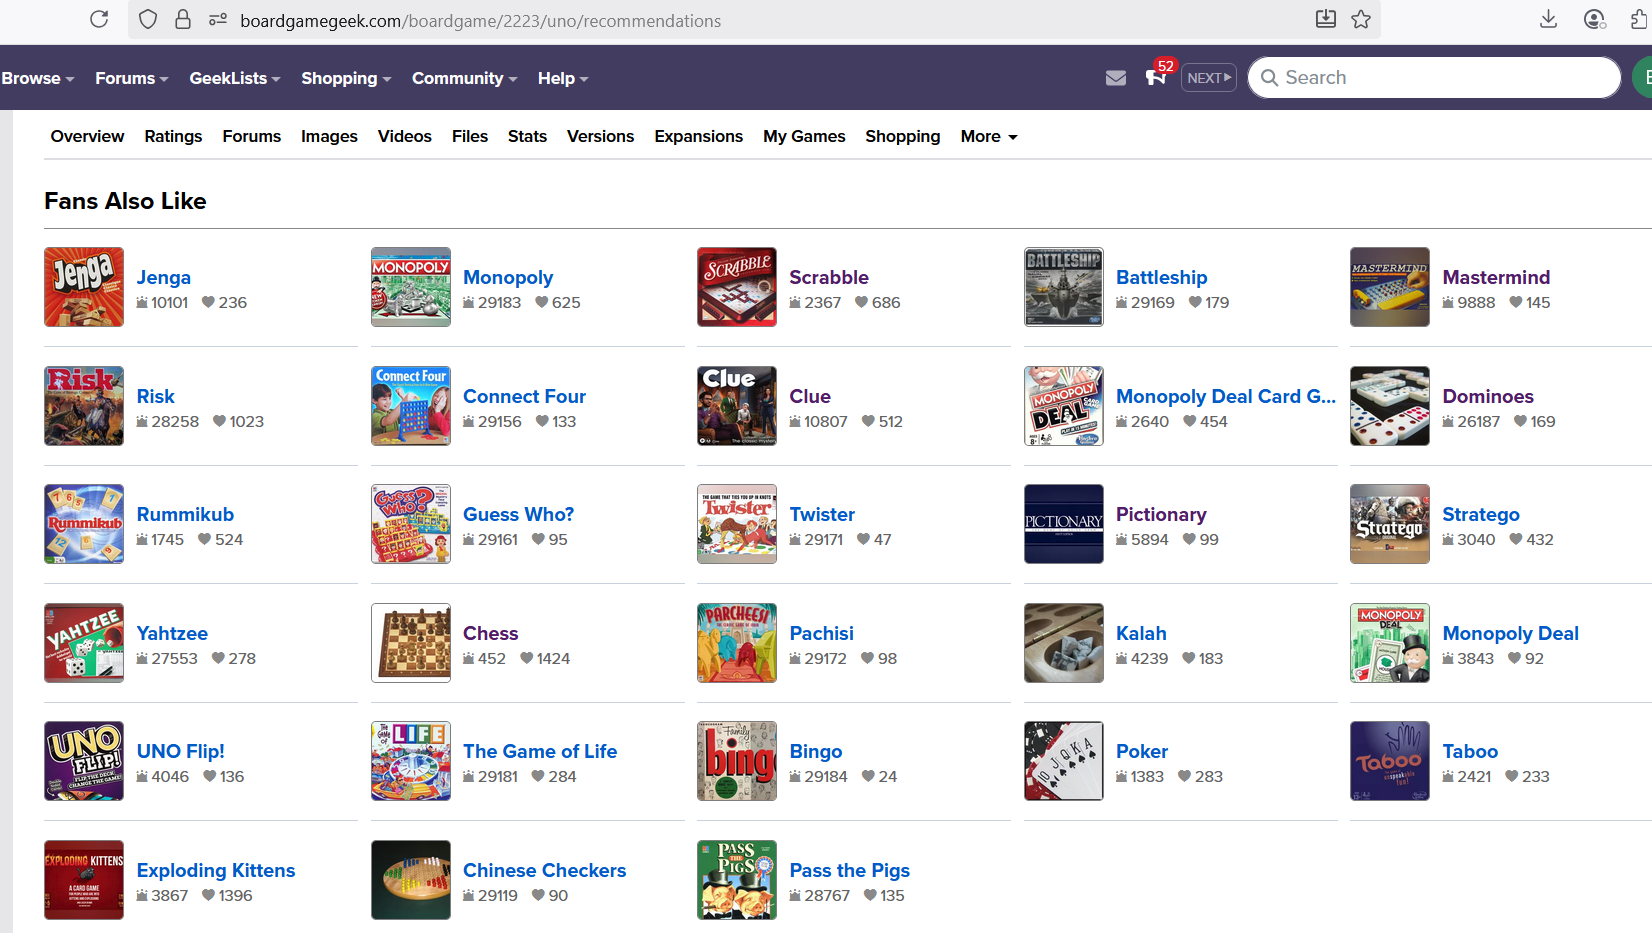

Uno is one of the most popular card games in terms of sales where players play cards to get rid of all of the cards in their hands.  There are many versions of this game, so I would expect recommendations to include them and other card games with related mechanics (drawing and playing cards that do something when played).

* Model Results:
    * Another version of Uno is in the recommendation, and Disney Villainous (another popular card/board game based in Disney's universe) is included. 
    * The other games do not appear to be the best matches, and honestly, I am not familiar with several of the ones recommended. 
    * Games that I would introduce to someone who likes Uno are omitted (Red7, Take 5, Love Letter, etc.)

* Boardgamegeek Recommendations:
    * Another version of Uno is in the recommendations, but I question the other choices like Chess, Stratego, Taboo, etc.
    * Also missing the typical games to introduce someone to who likes Uno.  
    * Some games are way too different to recommend (Twister, Pictionary, Bingo, Yahtzee, etc.)

Based on this analysis, I conclude the model gives slightly better recommendations.


### Random Input

In [103]:
random_list = list(search_df.sample(n=1, random_state=5)['Name'])
print(random_list)
recommend_games_from_game_list(random_list)

["trivial pursuit: the 1980's"]


['Trivial Pursuit: Genus 5',
 'Trivial Pursuit: Bet You Know It',
 'The Game Of Life (40Th Anniversary Edition)',
 'Scene It? Disney',
 'Run For Your Life, Candyman!',
 'Trivial Pursuit Dvd: Star Wars Saga Edition',
 'Trivial Pursuit: Dvd Pop Culture Game',
 'Soccer Tactics World',
 'Clue',
 'Clue: Dungeons & Dragons',
 "Harry Potter And The Sorcerer's Stone Trivia Game",
 'Trivial Pursuit: 25Th Anniversary Edition',
 'Formule Dé',
 'Gambler',
 'Trivial Pursuit: Totally 80S Edition',
 'Nur Peanuts!',
 'Clue: The Big Bang Theory',
 'I.Q. 2000',
 'Trivial Pursuit: Dvd - The Lord Of The Rings Trilogy Edition',
 'Rush Hour']

Random state 5 produced 'Trivial Pursuit: The 1980's', and the model recommends several trivia games as a result.  

In [105]:
random_list = list(search_df.sample(n=3, random_state=233414234)['Name'])
print(random_list)
recommend_games_from_game_list(random_list)

['18nl', 'timestreams: deck 1 - stone age vs. future tech', 'space base']


['Dice Forge',
 'Bunny Kingdom',
 'Gizmos',
 'Steam Park',
 'Meeple Circus',
 'To Court The King',
 'Rat-A-Tat Cat',
 'Machi Koro: Bright Lights, Big City',
 'Thanos Rising: Avengers Infinity War',
 'Pay Day',
 'Tussie Mussie',
 'Game Of Trains',
 'Wicked Witches Way',
 'Pyramids',
 'Lost Temple',
 'Smash Up: What Were We Thinking?',
 'Solo',
 'Chabyrinthe',
 'Anno Domini: Erfindungen',
 'Abandon All Artichokes']

18nl is a very involved and long game with lots of components and mechanism.  I am not familiar enough with Timestreams to talk intelligently about it.  Space Base is a game I play frequently online where players build a set of columns of cards and activate the abilities by rolling dice.

The recommendations overall look pretty good.  Gizmos and Machi Koro both rely building columns of cards and activating abilities in different ways while Tussie Mussie, Smash Up, and Abandon All Artichokes are more card driven games.  Game of Trains and Steam Park are similar in theme to 18nl, so that seems like a good match.  I have not played Anno Domini, but I have heard it is a very involved and heavy experience.


## **7. Conclusion** <a class="anchor" id="conclude"></a>

The goal of this project was to create a board game recommender to improve the single input version on Boardgamegeek, and a model and method to do this was successfully created based on the data.  The recommendations for single games were generally better than the ones from Boardgamegeek, and the recommendations based on a list were also very good.  

## **8. Appendix** <a class="anchor" id="append"></a>

The description of the columns from the dataset author's Kaggle post are listed below:

|variable                 |class     |description |
|:---|:---|:-------|
|ID                       |int       | BoardGameGeek ID Number |
|Name                     |character | Board game name  |
|Year Published           |int       | Year published  |
|Min Players              |int       | The minimum suggested number of players to play the game |
|Max Players              |int       | The maximum suggested number of players to play the game |
|Play Time                |int       | Average play time in minutes as suggested by the game creators |
|Min Age                  |int       | Age rating |
|Users Rated              |int       | Number of users who rated the game |
|Rating Average           |float64   | Average of user ratings |
|BGG Rank                 |int       | BoardGameGeek ranking |
|Complexity Average       |float64   | Average of user ratings for complexity from 1 - 5 |
|Owned Users              |int       | Number of users who own the game |
|Mechanics                |character | List of game mechanics for that game |
|Domains                  |character | List of game subgenres |